In [88]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import pandas as pd
import datetime 
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


## EDA

In [89]:
trial_df = pd.read_csv("cleaned_train/ArgentinaGermanyFinal77.csv")

In [90]:
trial_df.head()

,ID,MatchID,PeriodID,EventType,Timestamp,Tweet
0,10_0,10,0,0,1405277400000,@user: injury update: khedira (calf) is replac...
1,10_0,10,0,0,1405277400000,where does brazil's 2014 world cup campaign ra...
2,10_0,10,0,0,1405277400000,#arg for the world cup!!!
3,10_0,10,0,0,1405277400000,@user: rt for #ger \nfav for #arg \n\ni'll fol...
4,10_0,10,0,0,1405277400000,every mexican is rooting for argentina \nso i ...


In [91]:
trial_df.shape

(824241, 6)

In [92]:
trial_df[trial_df["EventType"]==1].shape

(298960, 6)

In [93]:
grouped_df = trial_df.groupby('ID').agg({'Timestamp': list,'Tweet': list,'EventType': list}).reset_index()

In [94]:
grouped_df["n_tweets"] = grouped_df["Tweet"].apply(lambda x: len(x))

In [95]:
grouped_df.shape

(180, 5)

In [96]:
grouped_df.head()

,ID,Timestamp,Tweet,EventType,n_tweets
0,10_0,"[1405277400000, 1405277400000, 1405277400000, ...",[@user: injury update: khedira (calf) is repla...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3672
1,10_1,"[1405277461000, 1405277461000, 1405277461000, ...",[tbh i don't care who wins i hate germany for ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3751
2,10_10,"[1405278001000, 1405278001000, 1405278001000, ...",[@user: stoked for the game! question is: do i...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",4060
3,10_100,"[1405283401000, 1405283401000, 1405283401000, ...","[missed again by #ger..\n\n#gervsarg, @user: i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4797
4,10_101,"[1405283461000, 1405283461000, 1405283461000, ...",[@user: i thought about the song instantly whe...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4664


In [97]:
grouped_df = grouped_df.sort_values("ID", key=(lambda x: x.apply(lambda y: int(y.split('_')[1]))))
grouped_df.reset_index(drop=True, inplace=True)

In [98]:
grouped_df.head()

,ID,Timestamp,Tweet,EventType,n_tweets
0,10_0,"[1405277400000, 1405277400000, 1405277400000, ...",[@user: injury update: khedira (calf) is repla...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3672
1,10_1,"[1405277461000, 1405277461000, 1405277461000, ...",[tbh i don't care who wins i hate germany for ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3751
2,10_2,"[1405277521000, 1405277521000, 1405277521000, ...","[@user: argentina better win fuck, #ger vs #ar...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3808
3,10_3,"[1405277581000, 1405277581000, 1405277581000, ...",[i want argentina to win cause of messi but i ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3990
4,10_4,"[1405277641000, 1405277641000, 1405277641000, ...","[game time! pizza, beer and chilled sunday! #a...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3775


In [99]:
grouped_df["n_tweets"].mean()

np.float64(4579.116666666667)

In [100]:
grouped_df["Assertion"] = grouped_df["EventType"].apply(lambda x: False if (1 in x) and (0 in x) else True)
grouped_df["Timestamp Assertion"] = grouped_df["Timestamp"].apply(lambda x: False if (len(set(x)) == 1) else True)
print(grouped_df["Assertion"].unique())
print(grouped_df["Timestamp Assertion"].unique())

[ True]
[ True]


In [101]:
grouped_df["EventType"] = grouped_df["EventType"].apply(lambda x: x[0])
grouped_df.drop(columns=["Assertion"], inplace=True)
grouped_df.drop(columns=["Timestamp Assertion"], inplace=True)
grouped_df.head()


,ID,Timestamp,Tweet,EventType,n_tweets
0,10_0,"[1405277400000, 1405277400000, 1405277400000, ...",[@user: injury update: khedira (calf) is repla...,0,3672
1,10_1,"[1405277461000, 1405277461000, 1405277461000, ...",[tbh i don't care who wins i hate germany for ...,0,3751
2,10_2,"[1405277521000, 1405277521000, 1405277521000, ...","[@user: argentina better win fuck, #ger vs #ar...",0,3808
3,10_3,"[1405277581000, 1405277581000, 1405277581000, ...",[i want argentina to win cause of messi but i ...,0,3990
4,10_4,"[1405277641000, 1405277641000, 1405277641000, ...","[game time! pizza, beer and chilled sunday! #a...",0,3775


In [102]:
grouped_df["Timestamp"] = grouped_df["Timestamp"].apply(lambda x: [datetime.datetime.fromtimestamp(y/1000) for y in x])
grouped_df.head()

,ID,Timestamp,Tweet,EventType,n_tweets
0,10_0,"[2014-07-13 20:50:00, 2014-07-13 20:50:00, 201...",[@user: injury update: khedira (calf) is repla...,0,3672
1,10_1,"[2014-07-13 20:51:01, 2014-07-13 20:51:01, 201...",[tbh i don't care who wins i hate germany for ...,0,3751
2,10_2,"[2014-07-13 20:52:01, 2014-07-13 20:52:01, 201...","[@user: argentina better win fuck, #ger vs #ar...",0,3808
3,10_3,"[2014-07-13 20:53:01, 2014-07-13 20:53:01, 201...",[i want argentina to win cause of messi but i ...,0,3990
4,10_4,"[2014-07-13 20:54:01, 2014-07-13 20:54:01, 201...","[game time! pizza, beer and chilled sunday! #a...",0,3775


In [103]:
grouped_df[grouped_df["EventType"]==1].shape

(64, 5)

In [104]:
n_tweets = grouped_df["n_tweets"].values
y = grouped_df["EventType"].values

In [105]:
print(f"The mean of the number of tweets when there is no critical event happening is {np.mean(n_tweets[y==0])} ± {np.std(n_tweets[y==0])}; and when there is a critical event happening is {np.mean(n_tweets[y==1])} ± {np.std(n_tweets[y==1])}")

The mean of the number of tweets when there is no critical event happening is 4528.2844827586205 ± 287.0164240775251; and when there is a critical event happening is 4671.25 ± 487.30415938097633


In [106]:
from collections import Counter

match_activity = Counter([])

for minute_timesteps in grouped_df["Timestamp"]:
    match_activity += Counter(minute_timesteps)

In [107]:
len(match_activity)

10801

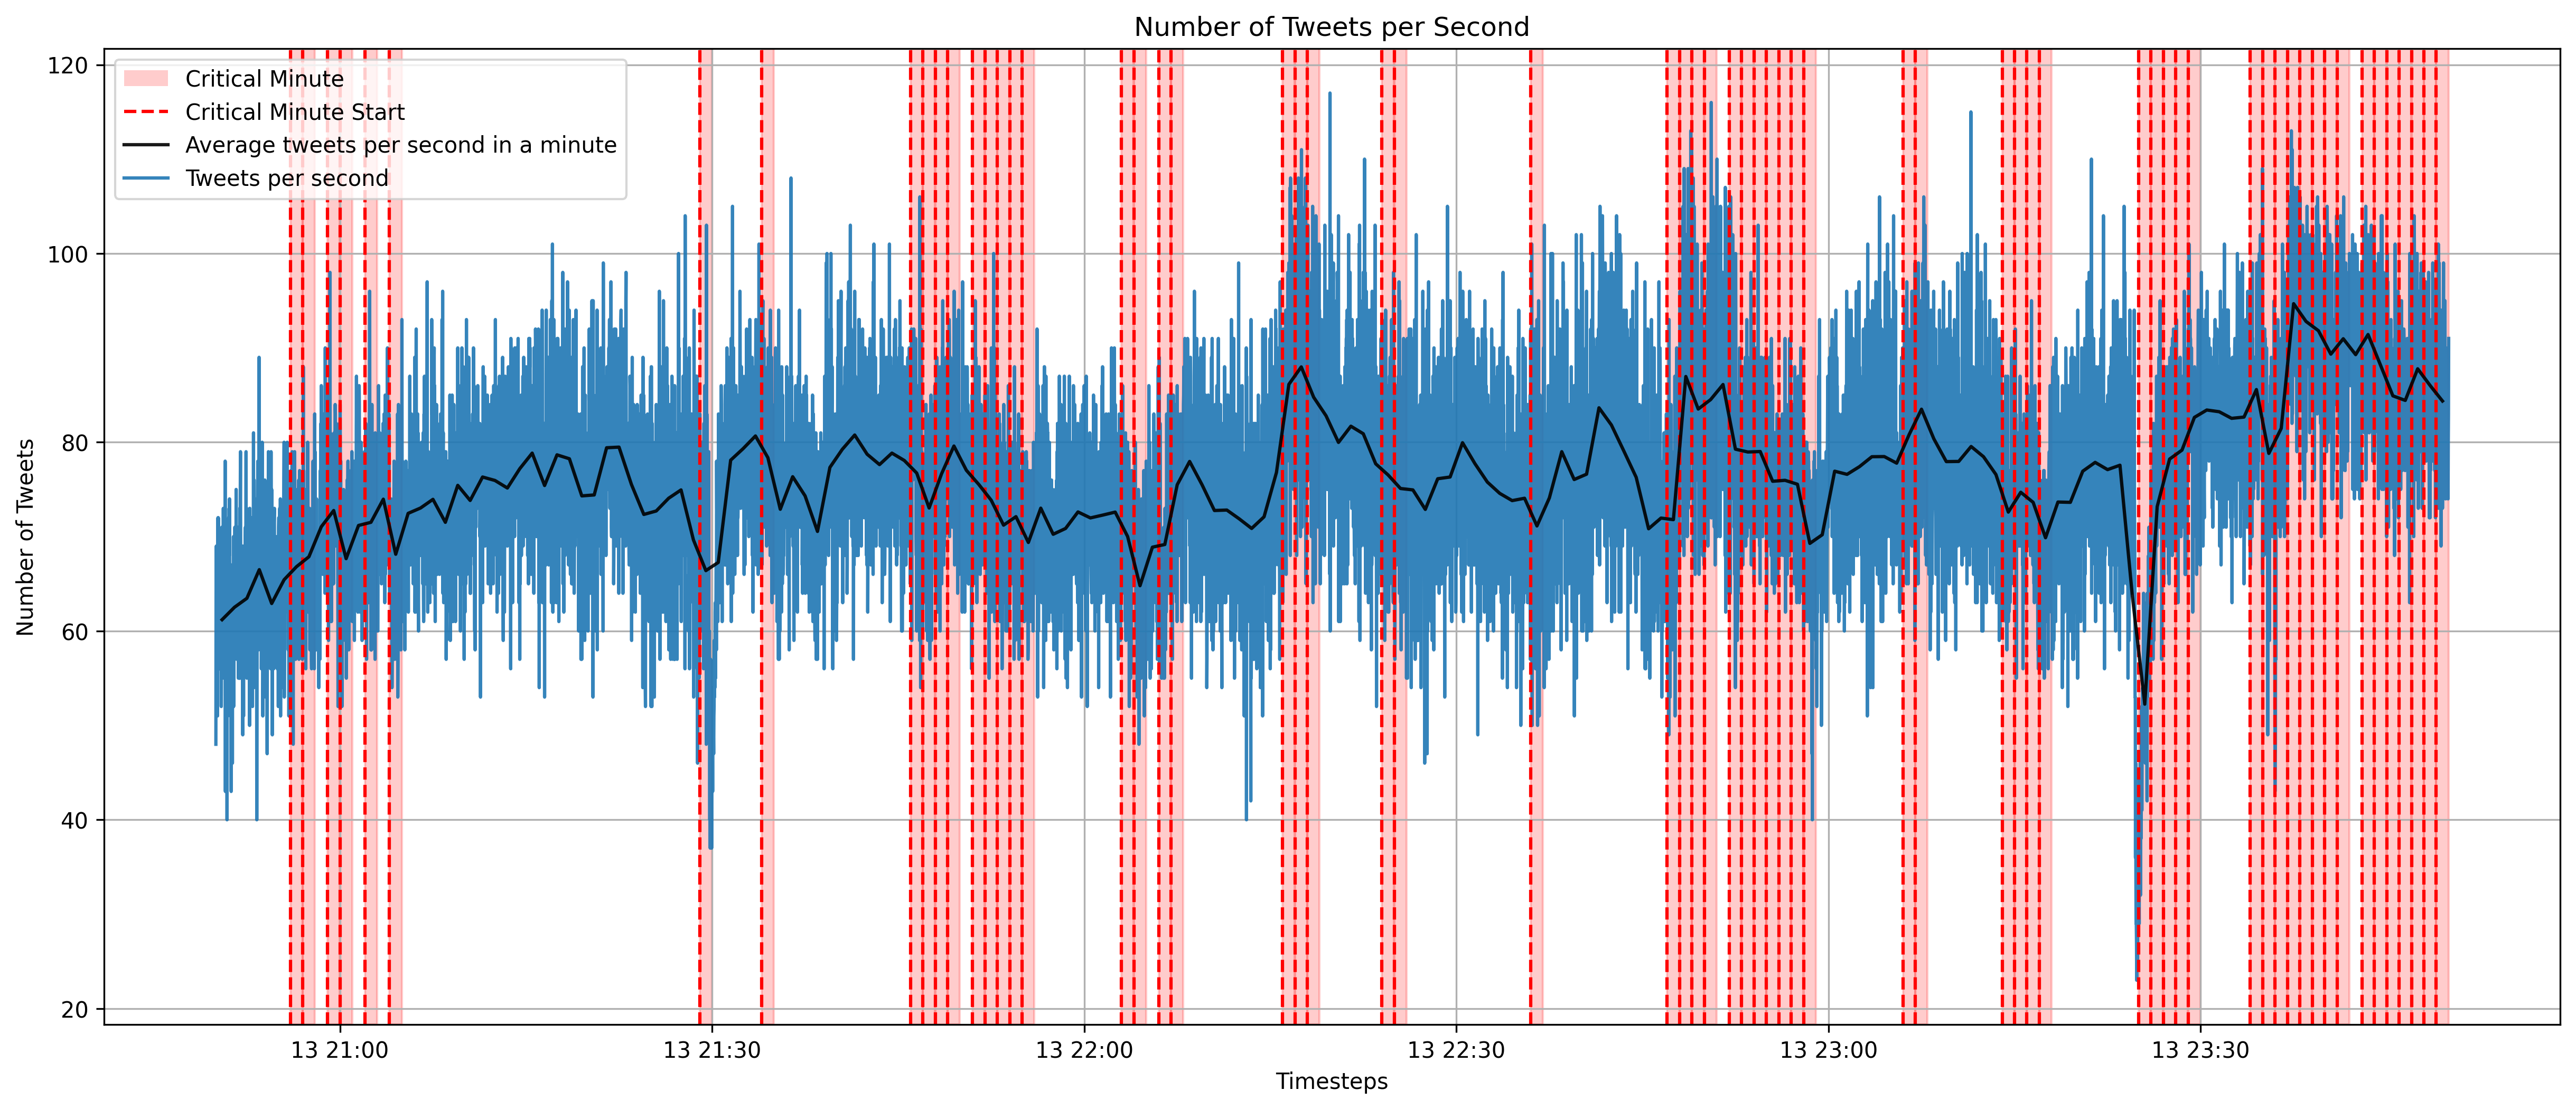

In [108]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.figure(figsize=(20, 8), dpi=300)
plt.plot(list(match_activity.keys()), list(match_activity.values()), alpha=0.9)

central_minute_seconds = []
for minute, outcome in enumerate(y):
    central_minute_seconds.append(list(match_activity.keys())[minute*60 + 30])
    if outcome == 1:
        start_second = list(match_activity.keys())[minute*60]
        end_second = list(match_activity.keys())[min((minute+1)*60-1, len(match_activity)-1)]
        plt.axvline(x=start_second, color="red", linestyle="--")
        plt.axvspan(start_second, end_second, color="red", alpha=0.2)

plt.plot(central_minute_seconds, (grouped_df["n_tweets"].values) / 60, color="black", linestyle="-", alpha=0.9)
plt.xlabel('Timesteps')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets per Second')
legend_elements = [
    Patch(facecolor='red', alpha=0.2, label='Critical Minute'),
    Line2D([0], [0], color='red', linestyle='--', label='Critical Minute Start'),
    Line2D([0], [0], color='black', alpha=0.9, linestyle='-', label='Average tweets per second in a minute'),
    Line2D([0], [0], alpha=0.9, linestyle='-', label='Tweets per second')
]
plt.legend(handles=legend_elements, loc='upper left')

plt.grid(True)
plt.show()

### Interactive graph

In [75]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import BoxAnnotation

# Enable notebook output
output_notebook()

# Create figure
p = figure(width=900, height=400, x_axis_label='Timesteps', y_axis_label='Number of Tweets',
          title='Number of Tweets per Second', tools='pan,box_zoom,reset,save,wheel_zoom')

# Add main activity line
p.line(list(match_activity.keys()), list(match_activity.values()), 
       line_color='blue', alpha=0.9, legend_label='Tweets per second')

# Add average line
p.line(central_minute_seconds, (grouped_df["n_tweets"].values) / 60, 
       line_color='black', line_width=2, legend_label='Average tweets per minute')

# Add critical minutes highlighting
for minute, outcome in enumerate(y):
    if outcome == 1:
        start_second = list(match_activity.keys())[minute*60]
        end_second = list(match_activity.keys())[min((minute+1)*60-1, len(match_activity)-1)]
        p.add_layout(BoxAnnotation(left=start_second, right=end_second,
                                 fill_color='red', fill_alpha=0.2))

# Configure legend
p.legend.click_policy="hide"
p.legend.location = "top_right"
p.grid.grid_line_alpha = 0.3

# Show the plot
show(p)

Loading BokehJS ...

REMARK: we might take a weighted average of the number of tweets per second over the minute we are considering (there might be an higher number of tweets per second in the seconds when something important happens).

## Performing some initial analysis on the Embeddings of the tweets

In [ ]:
assert False

In [2]:
BASE_MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
base_model = AutoModel.from_pretrained(BASE_MODEL_NAME).to(device)

In [20]:
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = base_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze()

def minute_embedding(texts):
    embeddings = [get_embedding(text) for text in texts]
    return torch.stack(embeddings).mean(dim=0).cpu().numpy()

In [21]:
from tqdm import tqdm

tqdm.pandas()
grouped_df["Embedding"] = grouped_df["Tweet"].progress_apply(lambda x: minute_embedding(x))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 130/130 [59:37<00:00, 27.52s/it]


In [22]:
grouped_df.head()

,ID,Timestamp,Tweet,EventType,n_tweets,Embedding
0,11_0,"[2014-07-05 17:50:00, 2014-07-05 17:50:00, 201...","[@user: argentina vs belgium\n\nwho wins? | , ...",0,2330,"[0.041983977, -0.08007118, 0.32538167, -0.0428..."
1,11_1,"[2014-07-05 17:51:01, 2014-07-05 17:51:01, 201...","[@user come on belgium, @user: messi and aguer...",0,2021,"[0.046064354, -0.07699028, 0.31636396, -0.0489..."
2,11_2,"[2014-07-05 17:52:01, 2014-07-05 17:52:01, 201...",[@user @user it happens for the world cup too ...,0,1775,"[0.059103355, -0.069916755, 0.30833194, -0.052..."
3,11_3,"[2014-07-05 17:53:01, 2014-07-05 17:53:01, 201...",[#arg vs #bel omg i like both teams but today ...,0,2291,"[0.047395326, -0.0755258, 0.3095702, -0.052382..."
4,11_4,"[2014-07-05 17:54:01, 2014-07-05 17:54:01, 201...",[argentina and belguim is gonna be such a gooo...,0,2456,"[0.05148725, -0.07734874, 0.31518087, -0.05672..."


In [ ]:
repr_2d_pca = PCA(n_components=2).fit_transform(np.stack(grouped_df["Embedding"].values))
repr_3d_pca = PCA(n_components=3).fit_transform(np.stack(grouped_df["Embedding"].values))

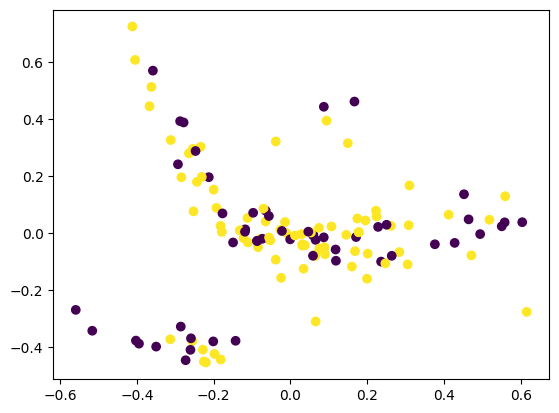

In [24]:
plt.scatter(repr_2d_pca[:, 0], repr_2d_pca[:, 1], c=y, cmap="viridis")

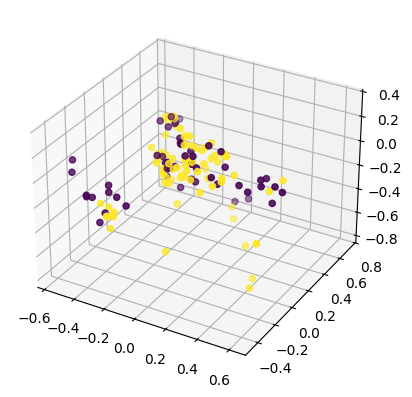

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(repr_3d_pca[:, 0], repr_3d_pca[:, 1], repr_3d_pca[:, 2], c=y, cmap="viridis")

In [27]:
from sklearn.manifold import TSNE

repr_2d_tsne = TSNE(n_components=2).fit_transform(np.stack(grouped_df["Embedding"].values))
repr_3d_tsne = TSNE(n_components=3).fit_transform(np.stack(grouped_df["Embedding"].values))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


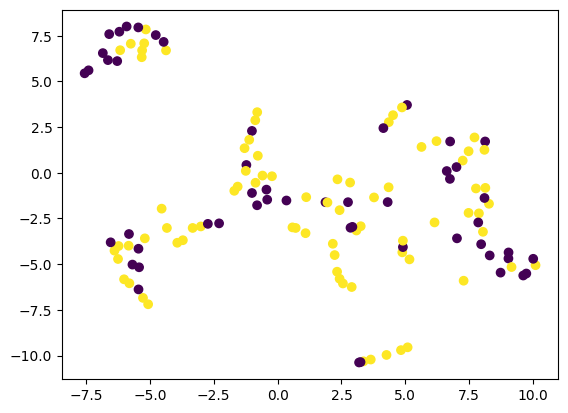

In [28]:
plt.scatter(repr_2d_tsne[:, 0], repr_2d_tsne[:, 1], c=y, cmap="viridis")

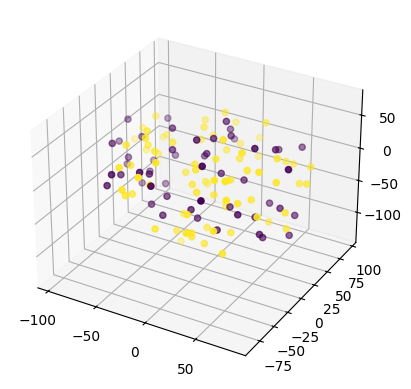

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(repr_3d_tsne[:, 0], repr_3d_tsne[:, 1], repr_3d_tsne[:, 2], c=y, cmap="viridis")